# EJERCICIO 1

Desarrollar un método computacional que, a partir de una imagen aérea, permita:
Segmentar las carreteras existentes en la imagen. Es decir, dada una imagen aérea, propor-
cionar una máscara binaria con los pı́xeles de carretera a 1 y el resto a 01 .
Proporcionar una evaluación cuantitativa de la segmentación usando el ground truth corres-
pondiente, usando una metodologı́a apropiada.

USAR MACHINE LEARNING -> PATERN RECOGNITION
    pipeline -> [extraccion de caracteristicas] -> NO seleccion de caracteristicas -> clasificacion

20 IMG
20 MASK

-------

SE ENTRENA CON LAS MASCARAS

    N-RANDOM O K-FOLD

TABLA PARA LA VALIDACION
    $\mu \pm \sigma$ 
- CLASIFICACION BINARIA PIXEL A PIXEL
    - CARRETA -> 1 | NO CARRETERA -> 0


buscar en librerias:
    baseline -> version mas simple
        vec de caracteristicas -> entra en el clasificador          -> salida mascara
                                            ^
                                            |
                                  otro vector de caracteristicas = mascara
    extractores de caracteristicas

vectores nxm con los 3 valores de los pixeles

aproximaciones:
    añadir caracteristicas -> aumenta el vector de caracteristicas
    

In [1]:
import sys
print ('\n'.join(sys.path))

/Users/pepe/anaconda3/lib/python311.zip
/Users/pepe/anaconda3/lib/python3.11
/Users/pepe/anaconda3/lib/python3.11/lib-dynload

/Users/pepe/Library/CloudStorage/OneDrive-UniversidadedaCoruña/carrera/3/1/pvc/entornoPvc/lib/python3.11/site-packages


In [2]:
import os

# Imprime el directorio actual de trabajo
print("Directorio actual:", os.getcwd())

# Verifica si el directorio existe
#ruta_base = "/home/clown/3-year/computer_vision/roads"
ruta_base = '../'
if os.path.exists(ruta_base):
    print("La ruta base existe")
else:
    print("La ruta base no existe")

Directorio actual: /Users/pepe/Library/CloudStorage/OneDrive-UniversidadedaCoruña/carrera/3/1/pvc/entornoPvc/PVC_investigacion
La ruta base existe


In [5]:
!pip install numpy
!pip install pre scikit-image
!pip install glob
!pip install opencv-python
!pip install matplotlib

ERROR: Could not find a version that satisfies the requirement glob (from versions: none)
ERROR: No matching distribution found for glob


In [3]:
import numpy as np
import skimage.io as io
import glob
import cv2

# Ruta a tus imágenes y máscaras

ruta_imagenes = glob.glob("../roads/sat/*.tif*")
ruta_mascaras = glob.glob("../roads/gt/*.tif*")

# image_paths = glob.glob("/home/clown/3-year/computer_vision/p3/sat/*.tiff")
# mask_paths = glob.glob("/home/clown/3-year/computer_vision/p3/gt/*.tif")

# Cargar imágenes y máscaras
imagenes = [io.imread(ruta_imagen) for ruta_imagen in ruta_imagenes]
mascaras = [io.imread(ruta_mascara) for ruta_mascara in ruta_mascaras]

# Redimensionar
if len(imagenes) > 0 and len(mascaras) > 0:
    imagenes = [cv2.resize(imagen, (256, 256)) for imagen in imagenes]
    mascaras = [cv2.resize(mascara, (256, 256)) for mascara in mascaras]
    print("Redimensionamiento completado.")
else:
    print("No se cargaron imágenes o máscaras.")

#print(image_paths)


Redimensionamiento completado.


In [4]:

def extraerCaracteristicas(imagen):
    # Vector de características RGB
    r, g, b = imagen[:, :, 0], imagen[:, :, 1], imagen[:, :, 2]
    # Matriz de valores RGB para cada pixel
    imagenPlana = np.stack((r.flatten(), g.flatten(), b.flatten()), axis=1)
    
    # Conversión a escala de grises y extracción de bordes con Canny
    gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
    bordes = cv2.Canny(gris, 80, 500).flatten()

    # Concatenar RGB y bordes en un solo vector de características
    caracteristicas = np.concatenate((imagenPlana, bordes[:, np.newaxis]), axis=1)
    return caracteristicas, bordes

# Aplicar extracción de características a todas las imágenes
caracteristicas = [extraerCaracteristicas(img)[0] for img in imagenes]
bordes = [extraerCaracteristicas(img)[1] for img in imagenes]


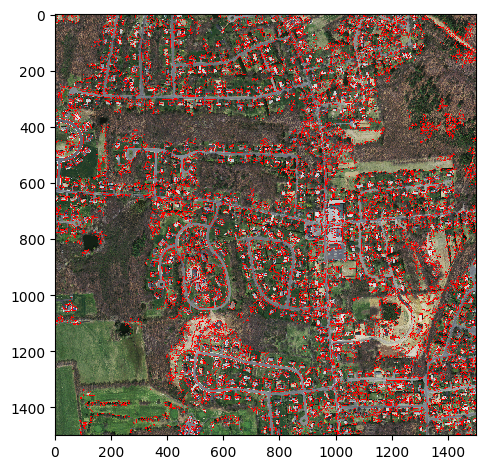

In [5]:
# ejemplo, vemos el efecto del método Canny de cv2 imprimiendo los "bordes"
# que detecta en rojo. Vemos que las cerreteras las detecta pero tambien 
# otras cosas que no son carreteras. Lógico

imagenEjemploBorde = io.imread('../roads/sat/10228705_15.tiff')
imagenEjemploBorde[np.reshape(extraerCaracteristicas(imagenEjemploBorde)[0][:,3] != 0,(1500,1500))] = [255,0,0]


io.imshow(imagenEjemploBorde);

# Clasificadores y métricas

Como clasificadorusaremos Random Forest y como métricas accuracy, precision, recall y f1score.

In [7]:
!pip install scikit-learn
!pip install xgboost

In [14]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
from time import time

# Aplanar las máscaras para obtener etiquetas (1 para carretera, 0 para no-carretera)
etiquetas = [mascara.flatten() for mascara in mascaras]

# Inicialización del clasificador y k-fold cross-validation
kf = KFold(n_splits=8)
metricas = {"accuracy": [], "precision": [], "recall": [], "f1": []}

iteracion = 0

for indicesEntrenamiento, indicesTest in kf.split(caracteristicas):
    antes = time()
    
    X_train = np.vstack([caracteristicas[i] for i in indicesEntrenamiento])
    y_train = np.hstack([etiquetas[i] for i in indicesEntrenamiento])
    X_test = np.vstack([caracteristicas[i] for i in indicesTest])
    y_test = np.hstack([etiquetas[i] for i in indicesTest])
    
    # Entrenar clasificador
    clasificador = RandomForestClassifier(n_estimators=50)
    clasificador.fit(X_train, y_train)
    
    # Evaluación en conjunto de prueba
    y_pred = clasificador.predict(X_test)
    metricas["accuracy"].append(accuracy_score(y_test, y_pred))
    metricas["precision"].append(precision_score(y_test, y_pred, average="macro"))
    metricas["recall"].append(recall_score(y_test, y_pred, average="macro"))
    metricas["f1"].append(f1_score(y_test, y_pred, average="macro",zero_division=np.nan)) # me lo recomendó la librería.

    despues = time()
    iteracion += 1
    print(f'Iteracion {iteracion}, llevó {despues - antes} segundos')
          
# Mostrar resultados de validación cruzada
for nombreMetrica, puntuaciones in metricas.items():
    print(f"{nombreMetrica.capitalize()}: {np.mean(puntuaciones):.4f} ± {np.std(puntuaciones):.4f}")


/Users/pepe/Library/CloudStorage/OneDrive-UniversidadedaCoruña/carrera/3/1/pvc/entornoPvc/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/pepe/Library/CloudStorage/OneDrive-UniversidadedaCoruña/carrera/3/1/pvc/entornoPvc/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteracion 1, llevó 82.78464198112488 segundos


/Users/pepe/Library/CloudStorage/OneDrive-UniversidadedaCoruña/carrera/3/1/pvc/entornoPvc/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/pepe/Library/CloudStorage/OneDrive-UniversidadedaCoruña/carrera/3/1/pvc/entornoPvc/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteracion 2, llevó 81.12145113945007 segundos


KeyboardInterrupt: 

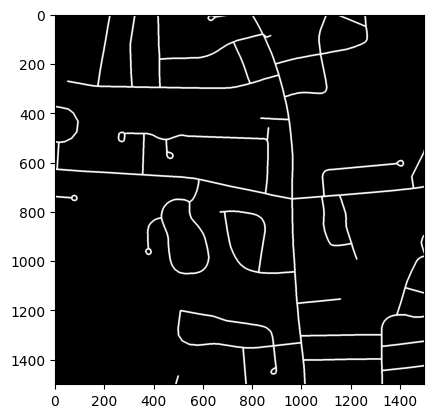

In [12]:
import matplotlib.pyplot as plt

new_image = io.imread("../roads/gt/10228705_15.tif")
plt.imshow(new_image, cmap="gray")
plt.show()

SOBRE ENTRENAMIENTO
USAR COMO LABELS 
    FOTO BLANCA
    FOTO NEGRA



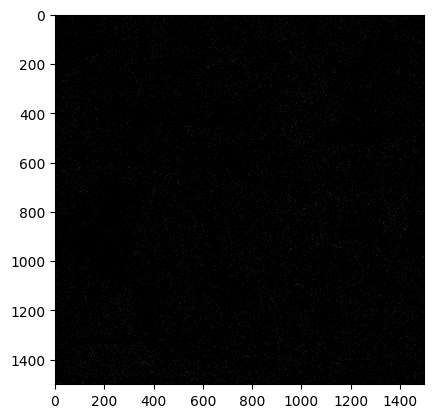

In [16]:
def predict_mask(image, model):
    features = extraerCaracteristicas(image)[0]
    mask_pred = model.predict(features)
    return mask_pred.reshape(image.shape[:2])

# Generar máscara para una nueva imagen
new_image = io.imread("../roads/sat/10228705_15.tiff")
mask_pred = predict_mask(new_image, clasificador)

# Mostrar la máscara predicha
import matplotlib.pyplot as plt
plt.imshow(mask_pred, cmap="gray")
plt.show()


In [40]:
# Comparar máscara predicha con ground truth
ground_truth = io.imread("../gt/10078675_15.tif")

accuracy = accuracy_score(ground_truth.flatten(), mask_pred.flatten())
precision = precision_score(ground_truth.flatten(), mask_pred.flatten(), average="macro")
recall = recall_score(ground_truth.flatten(), mask_pred.flatten(), average="macro")
f1 = f1_score(ground_truth.flatten(), mask_pred.flatten(), average="macro")

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


/home/clown/3-year/computer_vision/Computer-Vision/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.9727
Precision: 0.0042
Recall: 0.0042
F1 Score: 0.0042


# Ahora probaremos sólo pasandole la información de bordes

In [6]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
from time import time

# Aplanar las máscaras para obtener etiquetas (1 para carretera, 0 para no-carretera)
etiquetas = [mascara.flatten() for mascara in mascaras]

# Inicialización del clasificador y k-fold cross-validation
kf = KFold(n_splits=8)
metricas = {"accuracy": [], "precision": [], "recall": [], "f1": []}

iteracion = 0

for indicesEntrenamiento, indicesTest in kf.split(bordes):
    antes = time()
    
    X_train = np.vstack([bordes[i] for i in indicesEntrenamiento])
    y_train = np.hstack([etiquetas[i] for i in indicesEntrenamiento])
    X_test = np.vstack([bordes[i] for i in indicesTest])
    y_test = np.hstack([etiquetas[i] for i in indicesTest])
    
    # Entrenar clasificador
    clasificador = RandomForestClassifier(n_estimators=50)
    clasificador.fit(X_train, y_train)
    
    # Evaluación en conjunto de prueba
    y_pred = clasificador.predict(X_test)
    metricas["accuracy"].append(accuracy_score(y_test, y_pred))
    metricas["precision"].append(precision_score(y_test, y_pred, average="macro"))
    metricas["recall"].append(recall_score(y_test, y_pred, average="macro"))
    metricas["f1"].append(f1_score(y_test, y_pred, average="macro",zero_division=np.nan)) # me lo recomendó la librería.

    despues = time()
    iteracion += 1
    print(f'Iteracion {iteracion}, llevó {despues - antes} segundos')
          
# Mostrar resultados de validación cruzada
for nombreMetrica, puntuaciones in metricas.items():
    print(f"{nombreMetrica.capitalize()}: {np.mean(puntuaciones):.4f} ± {np.std(puntuaciones):.4f}")


ValueError: Found input variables with inconsistent numbers of samples: [17, 1114112]

In [15]:
clasificador = RandomForestClassifier(n_estimators=50)
clasificador.fit(bordes, etiquetas)

RandomForestClassifier(n_estimators=50)

In [29]:
miBorde = np.array(extraerCaracteristicas(io.imread('../roads/sat/10228705_15.tiff'))[1])
print(np.shape(miBorde))
clasificador.predict(miBorde)

(2250000,)


ValueError: Expected 2D array, got 1D array instead:
array=[  0.   0.   0. ...   0. 255.   0.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
# nota para el futuro, hay que probar un par de aelternativas más o por lo menos justificar
# basicamnete no podemos concluir esta parte hasta que lo que devuelva no tenga sentido

# EJERCICIO 2

Desarrollar un método computacional que, a partir de una imagen (y opcionalmente su máscara
de recorte), permita:
Identificar las imágenes que pertenecen a las categorı́as2 : “elephant” y “rhino”.
Proporcionar una evaluación cuantitativa adecuada de la identificaciones correspondientes

Es decir, clasificar cada imagen, considerando caracterı́sticas integradas para toda la imagen, región recortada y/o contorno, entre, por ejemplo, clase objetivo y resto

In [33]:
# hoooola chantada si lees esto puedes descansar, debería empezar yo esta porque la otra la hiciste tu toda